# **Imports**

In [5]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.6 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of mkl-fft to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-random to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of mkl-umath to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 59.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 53.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
import os
import yaml
import matplotlib.pyplot as plt
import cv2
from ultralytics import YOLO
from collections import defaultdict
import random
import glob

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


# **Read Data and EDA**

In [7]:
data_path = '/kaggle/input/egyptian-new-currency-2023/dataset'
train_path = os.path.join(data_path, 'train')
val_path = os.path.join(data_path, 'valid')  

print(f"Train path exists: {os.path.exists(train_path)}")
print(f"Val path exists: {os.path.exists(val_path)}")

Train path exists: True
Val path exists: True


In [8]:
classes = sorted([d for d in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, d))])
nc = len(classes)
print(f"Number of classes: {nc}")
print(f"Classes: {classes}") 

Number of classes: 9
Classes: ['1', '10', '10 (new)', '100', '20', '20 (new)', '200', '5', '50']


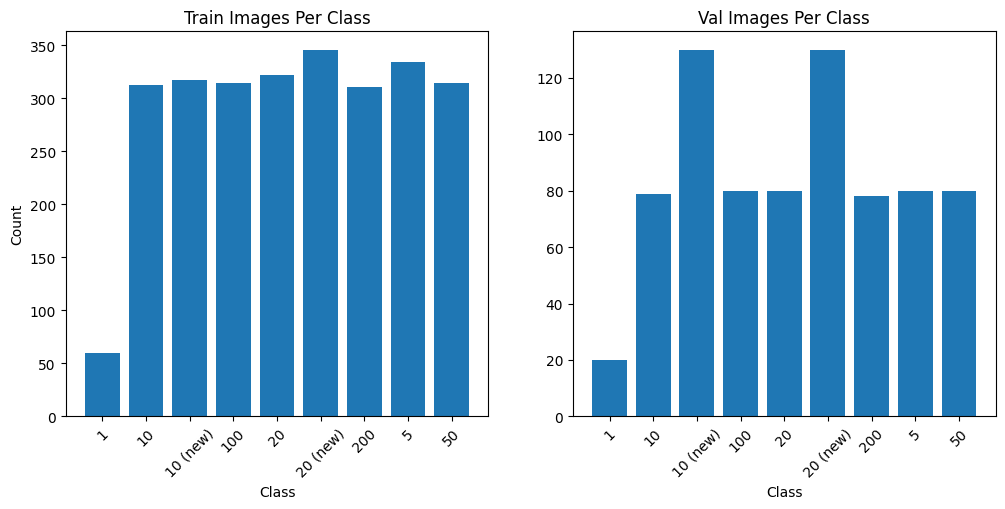

Total train images: 2633
Total val images: 757


In [9]:
train_counts = defaultdict(int)
val_counts = defaultdict(int)

for cls in classes:
    train_cls_path = os.path.join(train_path, cls)
    val_cls_path = os.path.join(val_path, cls)
    if os.path.exists(train_cls_path):
        train_counts[cls] = len([f for f in os.listdir(train_cls_path) if f.endswith('.jpg')])
    if os.path.exists(val_cls_path):
        val_counts[cls] = len([f for f in os.listdir(val_cls_path) if f.endswith('.jpg')])

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].bar(train_counts.keys(), train_counts.values())
ax[0].set_title('Train Images Per Class')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Count')
ax[0].tick_params(axis='x', rotation=45)

ax[1].bar(val_counts.keys(), val_counts.values())
ax[1].set_title('Val Images Per Class')
ax[1].set_xlabel('Class')
ax[1].tick_params(axis='x', rotation=45)
plt.show()

total_train = sum(train_counts.values())
total_val = sum(val_counts.values())
print(f"Total train images: {total_train}")
print(f"Total val images: {total_val}")

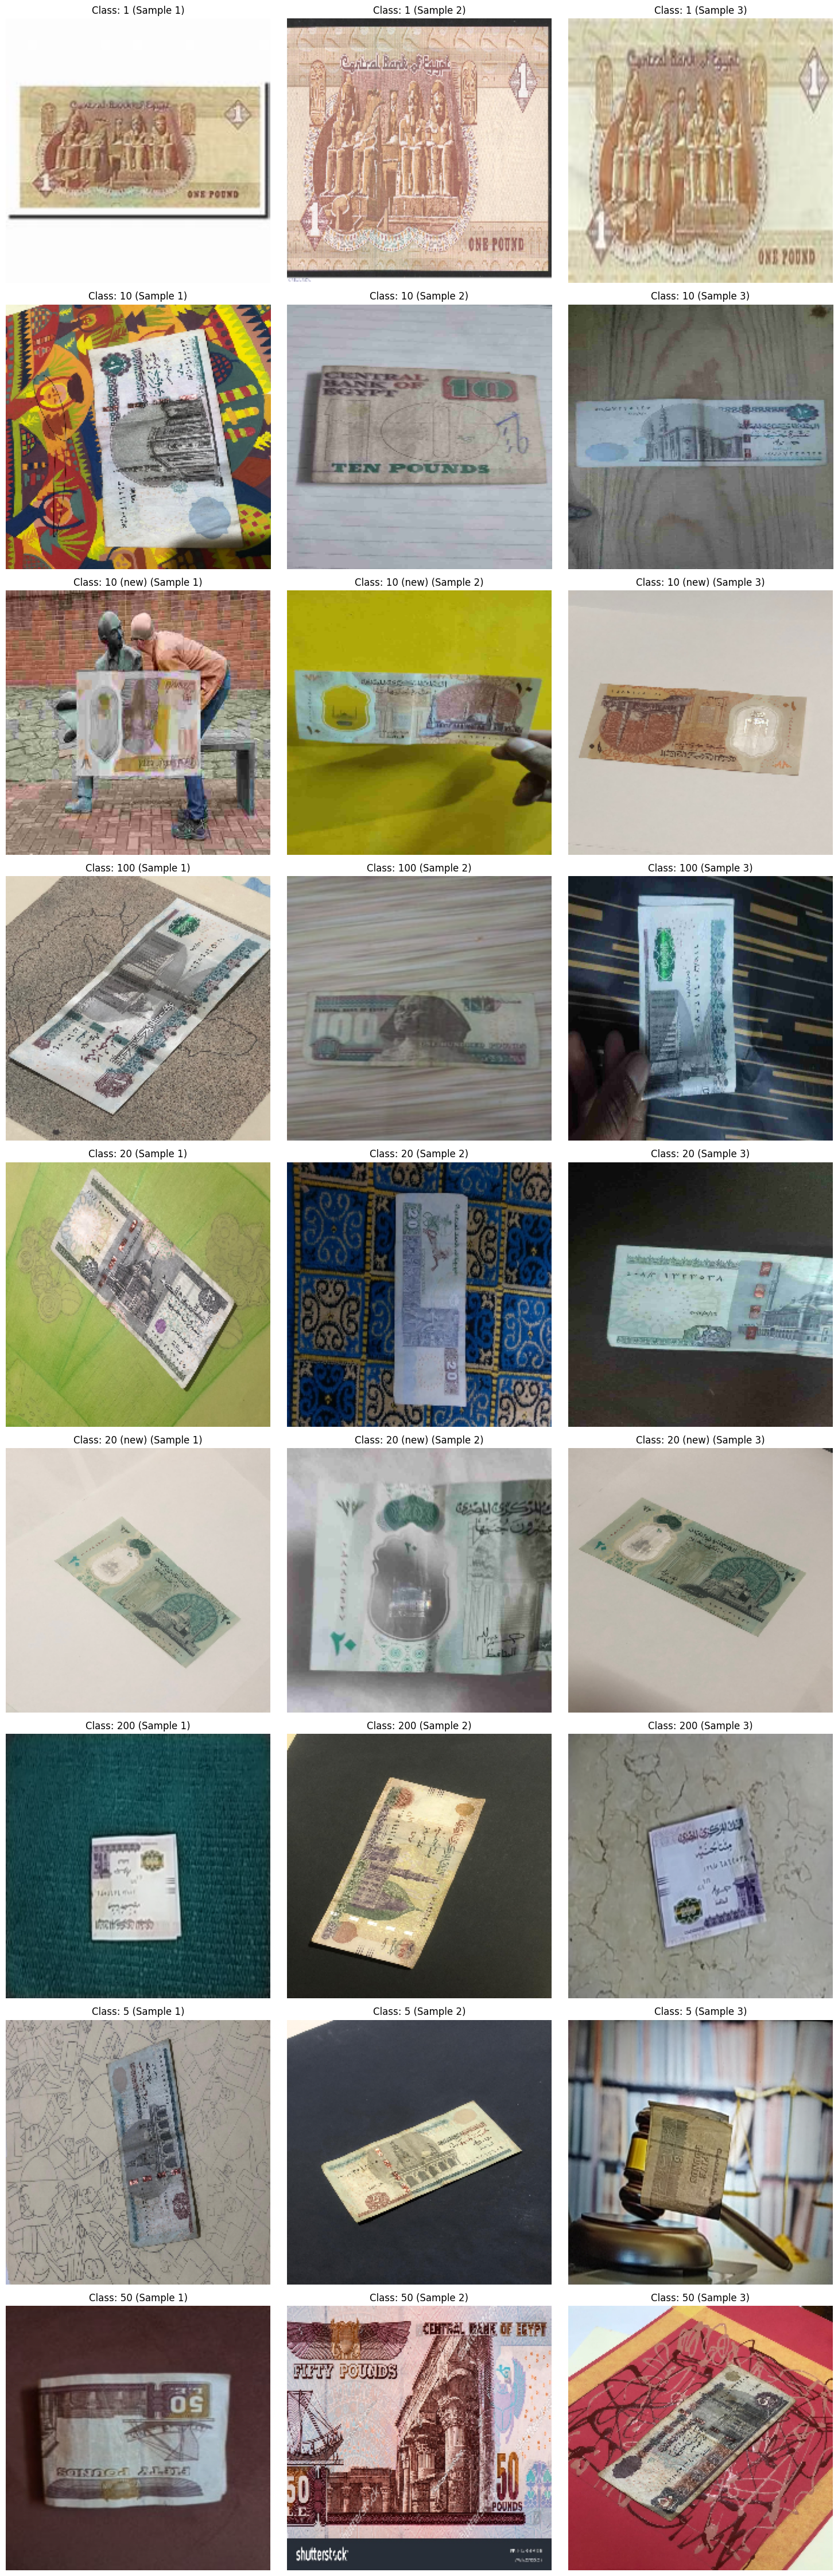

In [10]:
num_samples = 3
fig, axes = plt.subplots(nc, num_samples, figsize=(15, 5 * nc))  
axes = axes.flatten() if nc > 1 else [axes] 

for i, cls in enumerate(classes):
    cls_path = os.path.join(train_path, cls)
    images = [f for f in os.listdir(cls_path) if f.endswith('.jpg')]
    if images:
        for j in range(num_samples):
            if j < len(images):
                img_path = os.path.join(cls_path, random.choice(images))
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
                img = cv2.resize(img, (224, 224)) 
                ax_idx = i * num_samples + j
                axes[ax_idx].imshow(img)  
                axes[ax_idx].set_title(f"Class: {cls} (Sample {j+1})")
                axes[ax_idx].axis('off')
            else:
                axes[i * num_samples + j].axis('off')
plt.tight_layout()
plt.show()

In [11]:
sample_sizes = []
for cls in classes:
    cls_path = os.path.join(train_path, cls)
    images = [f for f in os.listdir(cls_path) if f.endswith('.jpg')]
    if images:
        img_path = os.path.join(cls_path, images[0])
        img = cv2.imread(img_path)
        sample_sizes.append((cls, img.shape)) 

print("Sample image sizes (class, (H, W, C)):")
for s in sample_sizes:
    print(s)

Sample image sizes (class, (H, W, C)):
('1', (101, 201, 3))
('10', (1280, 720, 3))
('10 (new)', (427, 640, 3))
('100', (1280, 960, 3))
('20', (960, 1280, 3))
('20 (new)', (427, 640, 3))
('200', (1280, 960, 3))
('5', (360, 480, 3))
('50', (720, 1280, 3))


# **Create Yaml File**

In [12]:
yaml_data = {
    'path': '/kaggle/input/egyptian-new-currency-2023/dataset',  
    'train': 'train',  
    'val': 'test',     
    'nc': len(classes),  
    'names': classes    
}

yaml_path = '/kaggle/working/currency.yaml'
with open(yaml_path, 'w') as f:
    yaml.dump(yaml_data, f, default_flow_style=False)

print(f"YAML created at: {yaml_path}")
with open(yaml_path, 'r') as f:
    print(f.read())

YAML created at: /kaggle/working/currency.yaml
names:
- '1'
- '10'
- 10 (new)
- '100'
- '20'
- 20 (new)
- '200'
- '5'
- '50'
nc: 9
path: /kaggle/input/egyptian-new-currency-2023/dataset
train: train
val: test



# **Train Model**

In [16]:
model = YOLO('yolo11n-cls.pt') 

results = model.train(
    data='/kaggle/input/egyptian-new-currency-2023/dataset',  
    epochs=50,      
    imgsz=224,      
    batch=16,       
    name='egyptian_currency_clf',  
    patience=10,    
    lr0=0.01,        
    optimizer='AdamW',
    augment=True,    
    cache=True   
)

Ultralytics 8.3.217 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/input/egyptian-new-currency-2023/dataset, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=egyptian_currency_clf4, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      0.991          1
Speed: 0.1ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /kaggle/working/runs/classify/egyptian_currency_clf4


# **Evaluate Model**

In [22]:
val_metrics = model.val(data='/kaggle/input/egyptian-new-currency-2023/dataset', split='test')
print("Test Set Metrics:")
print(val_metrics)

Ultralytics 8.3.217 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
train: /kaggle/input/egyptian-new-currency-2023/dataset/train... found 2637 images in 9 classes ✅ 
val: /kaggle/input/egyptian-new-currency-2023/dataset/valid... found 760 images in 9 classes ✅ 
test: /kaggle/input/egyptian-new-currency-2023/dataset/test... found 290 images in 9 classes ✅ 
test: Fast image access ✅ (ping: 0.4±0.0 ms, read: 11.9±1.3 MB/s, size: 5.8 KB)
test: Scanning /kaggle/input/egyptian-new-currency-2023/dataset/test... 288 images, 2 corrupt: 100% ━━━━━━━━━━━━ 290/290 806.0it/s 0.4s1.4s
test: /kaggle/input/egyptian-new-currency-2023/dataset/test/20/20.3.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/egyptian-new-currency-2023/dataset/test/20/20.3.jpg'
test: /kaggle/input/egyptian-new-currency-2023/dataset/test/50/50.1.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/egyptian-new-currency-2023/dataset/test/50/50.1.j

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      0.983          1
Speed: 0.1ms preprocess, 0.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /kaggle/working/runs/classify/val5
Test Set Metrics:
ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e227015e890>
curves: []
curves_results: []
fitness: 0.9913194477558136
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9826388955116272, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9913194477558136}
save_dir: PosixPath('/kaggle/working/runs/classify/val5')
speed: {'preprocess': 0.06284956945200469, 'inference': 0.47324403819478295, 'loss': 0.0008672361073220398, 'postprocess': 0.0013521493100496528}
task: 'classify'
top1: 0.9826388955116272
top5: 1.0


In [21]:
metrics = model.val(data='/kaggle/input/egyptian-new-currency-2023/dataset')
print(metrics)

Ultralytics 8.3.217 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
train: /kaggle/input/egyptian-new-currency-2023/dataset/train... found 2637 images in 9 classes ✅ 
val: /kaggle/input/egyptian-new-currency-2023/dataset/valid... found 760 images in 9 classes ✅ 
test: /kaggle/input/egyptian-new-currency-2023/dataset/test... found 290 images in 9 classes ✅ 
val: Fast image access ✅ (ping: 1.5±0.2 ms, read: 15.3±4.0 MB/s, size: 6.9 KB)
val: Scanning /kaggle/input/egyptian-new-currency-2023/dataset/valid... 759 images, 1 corrupt: 100% ━━━━━━━━━━━━ 760/760 1.5Kit/s 0.5s0.1ss
val: /kaggle/input/egyptian-new-currency-2023/dataset/valid/100/100.3.jpg: ignoring corrupt image/label: [Errno 30] Read-only file system: '/kaggle/input/egyptian-new-currency-2023/dataset/valid/100/100.3.jpg'
WARNING ⚠️ val: Cache directory /kaggle/input/egyptian-new-currency-2023/dataset is not writeable, cache not saved.
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 48/48 6.5it/s 7.4

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all      0.991          1
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /kaggle/working/runs/classify/val4
ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e223db09150>
curves: []
curves_results: []
fitness: 0.9953886568546295
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.990777313709259, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9953886568546295}
save_dir: PosixPath('/kaggle/working/runs/classify/val4')
speed: {'preprocess': 0.12920956126104144, 'inference': 0.5561533728619338, 'loss': 0.0007629354434396626, 'postprocess': 0.0012187628426509466}
task: 'classify'
top1: 0.990777313709259
top5: 1.0


# **Check for Overfitting**

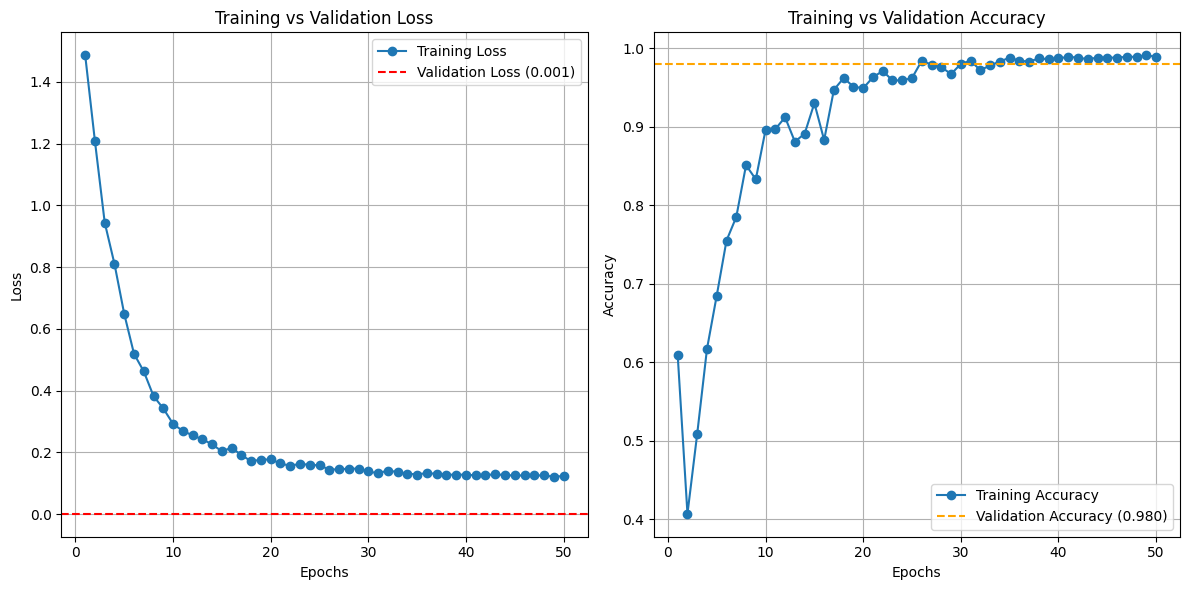

In [18]:
import matplotlib.pyplot as plt

epochs = 50
train_losses = [1.486, 1.207, 0.944, 0.810, 0.648, 0.519, 0.462, 0.382, 0.342, 0.292,
0.269, 0.255, 0.242, 0.226, 0.203, 0.215, 0.191, 0.171, 0.176, 0.177,
0.164, 0.156, 0.163, 0.159, 0.158, 0.144, 0.145, 0.147, 0.147, 0.138,
0.132, 0.141, 0.136, 0.131, 0.128, 0.133, 0.130, 0.128, 0.127, 0.128,
0.125, 0.126, 0.129, 0.126, 0.125, 0.125, 0.125, 0.125, 0.121, 0.123
]  
train_accuracies = [0.609, 0.407, 0.509, 0.617, 0.685, 0.755, 0.785, 0.851, 0.833, 0.896,
0.897, 0.912, 0.881, 0.891, 0.93, 0.883, 0.947, 0.962, 0.951, 0.949,
0.963, 0.971, 0.959, 0.959, 0.962, 0.984, 0.979, 0.976, 0.967, 0.98,
0.984, 0.972, 0.978, 0.983, 0.988, 0.984, 0.983, 0.987, 0.986, 0.987,
0.989, 0.988, 0.986, 0.988, 0.988, 0.988, 0.989, 0.989, 0.991, 0.989
]

val_loss = 0.00081
val_accuracy = 0.98

epoch_list = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epoch_list, train_losses, label='Training Loss', marker='o')
plt.axhline(y=val_loss, color='red', linestyle='--', label=f'Validation Loss ({val_loss:.3f})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epoch_list, train_accuracies, label='Training Accuracy', marker='o')
plt.axhline(y=val_accuracy, color='orange', linestyle='--', label=f'Validation Accuracy ({val_accuracy:.3f})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
